# XGBoost. The very best there is. When you absolutely, positively got to forecast everything in the room, accept no substitutes.

## Let's get started!

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

## Import Dataset

In [2]:
# read data in
df = pd.read_csv('Data for Price Predicting_033118.csv', index_col='Unnamed: 0', low_memory=False)

In [3]:
df.head()

,ACRES,APPLIANCES,AssociationFee,BASEMENT,BATHDESC,BATHQUARTER,BATHSTHREEQUARTER,BATHSTOTAL,BathsFull,BathsHalf,...,REM_Remodel,REM_Full_Remodel_Rehabbed,FIN_Warranty,FIN_Pre_Approved,FIN_Contribution,FIN_FHA,FIN_DVA,FIN_Quick,REM_FIN_As_Is,REM_FIN_Rehab
0,3.200,"Range, Cooktop, Microwave, Dishwasher, Refrige...",0,"Walkout, Full, Finished (Livable), Day/Lookout...","Main Floor 1/2 Bath, Full Master, Walk Thru, 3...",0,1,3,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.786,"Microwave, Exhaust Fan/Hood, Dishwasher, Washe...",0,"Full, Concrete Block","Main Floor 1/2 Bath, Upper Level Full Bath , P...",0,0,3,2,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.233,"Cooktop, Wall Oven, Dishwasher, Washer, Dryer",0,Full,NaN,0,1,3,2,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.300,"Cooktop, Wall Oven, Exhaust Fan/Hood, Dishwash...",0,"Full, Finished (Livable), Drain Tiled, Sump Pu...","Main Floor 3/4 Bath, Upper Level Full Bath , P...",0,3,4,1,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.730,"Range, Microwave, Exhaust Fan/Hood, Dishwasher...",750,"Walkout, Full, Finished (Livable), Day/Lookout...","Main Floor 1/2 Bath, Upper Level Full Bath , P...",0,1,4,2,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 128 entries, ACRES to REM_FIN_Rehab
dtypes: float64(58), int64(35), object(35)
memory usage: 4.9+ MB


In [5]:
df.columns.values

array(['ACRES', 'APPLIANCES', 'AssociationFee', 'BASEMENT', 'BATHDESC',
       'BATHQUARTER', 'BATHSTHREEQUARTER', 'BATHSTOTAL', 'BathsFull',
       'BathsHalf', 'Bedrooms', 'City', 'CoolingDescription',
       'DAYSONMARKET', 'DiningRoomDescription', 'EXTERIOR', 'FENCE',
       'FOUNDATIONSIZE', 'Fireplaces', 'Foreclosure', 'GarageDescription',
       'LAKEWATERFRONT', 'LISTDATE', 'LISTPRICE', 'LakeAcres',
       'LotSizeDimensions', 'MLNumber', 'OriginalListPrice',
       'PoolDescription', 'PostalCode', 'PotentialShortSale',
       'PricePerTSFT', 'REMARKS', 'REMARKSFINANCIAL', 'ROOF',
       'ROOMFAMILYCHAR', 'SEWER', 'SQFTABOVEGROUND', 'SQFTBELOWGROUND',
       'STYLE', 'SalesCloseDate', 'SalesClosePrice',
       'SchoolDistrictNumber', 'StateOrProvince', 'TAXYEAR', 'Taxes',
       'YEARBUILT', 'agencyname', 'agencyori', 'aggravated_assault',
       'all_other_offenses', 'arson', 'burglary', 'county',
       'curfew_and_loitering', 'disorderly_conduct', 'drug_abuse', 'dui',
      

In [6]:
# Change prices to float from string
df[['LISTPRICE', 'OriginalListPrice', 'PricePerTSFT', 'SalesClosePrice']] = df[['LISTPRICE', 'OriginalListPrice', 'PricePerTSFT', 'SalesClosePrice']].replace('[\$,]','',regex=True).astype(float)

In [7]:
# CSVs are dumb, sometimes need to force things to numeric
#cols = df.columns
#df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
#df.shape

## Filter out Jumbo loans and tiny sale prices

In [8]:
df1 = df[(df['SalesClosePrice'] >= 120000) & (df['SalesClosePrice'] < 453000)]
df1.shape

(4376, 128)

In [14]:
df0 = df1.select_dtypes(include=['object'])

In [15]:
df0.columns.values

array(['APPLIANCES', 'BASEMENT', 'BATHDESC', 'City', 'CoolingDescription',
       'DiningRoomDescription', 'EXTERIOR', 'FENCE', 'Foreclosure',
       'GarageDescription', 'LAKEWATERFRONT', 'LISTDATE',
       'LotSizeDimensions', 'PoolDescription', 'PotentialShortSale',
       'REMARKS', 'REMARKSFINANCIAL', 'ROOF', 'ROOMFAMILYCHAR', 'SEWER',
       'STYLE', 'SalesCloseDate', 'SchoolDistrictNumber',
       'StateOrProvince', 'agencyname', 'agencyori', 'county',
       'offense_type', 'period', 'streetaddress', 'grade'], dtype=object)

In [10]:
df2 = df1.select_dtypes(exclude=['object'])

In [12]:
df2.columns.values

array(['ACRES', 'AssociationFee', 'BATHQUARTER', 'BATHSTHREEQUARTER',
       'BATHSTOTAL', 'BathsFull', 'BathsHalf', 'Bedrooms', 'DAYSONMARKET',
       'FOUNDATIONSIZE', 'Fireplaces', 'LISTPRICE', 'LakeAcres',
       'MLNumber', 'OriginalListPrice', 'PostalCode', 'PricePerTSFT',
       'SQFTABOVEGROUND', 'SQFTBELOWGROUND', 'SalesClosePrice', 'TAXYEAR',
       'Taxes', 'YEARBUILT', 'aggravated_assault', 'all_other_offenses',
       'arson', 'burglary', 'curfew_and_loitering', 'disorderly_conduct',
       'drug_abuse', 'dui', 'embezzlement', 'family_and_children',
       'forgery_and_counterfeiting', 'fraud', 'gambling', 'grand_total',
       'human_trafficking', 'larceny', 'liquor_laws', 'manslaughter',
       'motor_vehicle_theft', 'murder', 'other_assaults',
       'other_sex_offenses', 'part_i_total', 'part_ii_total',
       'population', 'prostitution', 'rape', 'robbery', 'runaways',
       'stolen_property', 'suspicion', 'vagrancy', 'vandalism', 'weapons',
       'NEAR_DIST', 'Rank

## Build the first Model

In [16]:
# select X & Y
y = 'SalesClosePrice'
feature_names = list(df2.columns.values)
feature_names.remove(y)

### 1. Split Data into Test & Train

In [17]:
# split data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(df2[feature_names], df2[y], test_size=0.6)

In [18]:
# keep labels on test/train
X_train = pd.DataFrame(data=Xtrain, columns=feature_names)
X_test = pd.DataFrame(data=Xtest, columns=feature_names)

dtrain = xgb.DMatrix(Xtrain, label=ytrain)

### 2. Fit the Model to the training set

In [19]:
eval_set = [(Xtest, ytest)]
model_xgb = xgb.XGBRegressor(n_jobs=4, eval_metric='rmse', eval_set=eval_set, early_stopping_rounds=50)
model_xgb.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=50, eval_metric='rmse',
       eval_set=[(      ACRES  AssociationFee  BATHQUARTER  BATHSTHREEQUARTER  BATHSTOTAL  \
3006  0.240               0            0                  1           2
758   0.110               0            0                  0           1
683   0.137               0            0                  0     ...    213000.0
3617    168900.0
3753    186000.0
Name: SalesClosePrice, Length: 2626, dtype: float64)],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### 3. Make predictions for test data

In [20]:
ypred = model_xgb.predict(Xtest)
predictions = [round(value) for value in ypred]

## Evaluate the model

### Metrics to use

* metrics.explained_variance_score(y_true, y_pred)
 + Explained variance regression score function
* metrics.mean_absolute_error(y_true, y_pred)
 + Mean absolute error regression loss
* metrics.mean_squared_error(y_true, y_pred[, …])
 + Mean squared error regression loss
* metrics.mean_squared_log_error(y_true, y_pred)
 + Mean squared logarithmic error regression loss
* metrics.median_absolute_error(y_true, y_pred)
 + Median absolute error regression loss
* metrics.r2_score(y_true, y_pred[, …])
 + R^2 (coefficient of determination) regression score function.

### R^2 Metric

In [21]:
# evaluate predictions
r2_score(ytest, ypred)

0.9907796703350205

### RMSE Metric

In [22]:
from math import sqrt
rmse = sqrt(mean_squared_error(ytest, ypred))
rmse

7803.283142616031

### Difference between R^2 and RMSE

Both indicate the goodness of the fit.

R-squared is conveniently scaled between 0 and 1, whereas RMSE is not scaled to any particular values. This can be good or bad; obviously R-squared can be more easily interpreted, but with RMSE we explicitly know how much our predictions deviate, on average, from the actual values in the dataset. So in a way, RMSE tells you more.

## Tuning the Model

### Control Overfitting

When you observe high training accuracy, but low tests accuracy, it is likely that you encounter overfitting problem.

There are in general two ways that you can control overfitting in xgboost

* The first way is to directly control model complexity
 + This include max_depth, min_child_weight and gamma
* The second way is to add randomness to make training robust to noise
 + This include subsample, colsample_bytree
* You can also reduce stepsize eta, but needs to remember to increase num_round when you do so.

In [24]:
# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': [2, 3, 4], 
                     'min_child_weight': [0.1, 0.5, 0.75]
                    }]


print("# Tuning hyper-parameters for r2")
print()

model = GridSearchCV(xgb.XGBRegressor(n_jobs=4), tuned_parameters, cv=5, scoring='r2')
model.fit(Xtrain, ytrain)

print("Best parameters set found on development set:")
print()
print(model.best_params_)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'max_depth': 2, 'min_child_weight': 0.1}

Grid scores on development set:

0.990 (+/-0.003) for {'max_depth': 2, 'min_child_weight': 0.1}
0.990 (+/-0.003) for {'max_depth': 2, 'min_child_weight': 0.5}
0.990 (+/-0.003) for {'max_depth': 2, 'min_child_weight': 0.75}
0.990 (+/-0.003) for {'max_depth': 3, 'min_child_weight': 0.1}
0.990 (+/-0.003) for {'max_depth': 3, 'min_child_weight': 0.5}
0.990 (+/-0.003) for {'max_depth': 3, 'min_child_weight': 0.75}
0.990 (+/-0.003) for {'max_depth': 4, 'min_child_weight': 0.1}
0.990 (+/-0.003) for {'max_depth': 4, 'min_child_weight': 0.5}
0.990 (+/-0.003) for {'max_depth': 4, 'min_child_weight': 0.75}


### Explore the 'best' model

In [25]:
# split data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(df2[feature_names], df2[y], test_size=0.25)

In [26]:
# fit model on training data
model_best = xgb.XGBRegressor(max_depth=3, min_child_weight=0.1, n_jobs=4)
model_best.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=0.1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Make predictions for test data

In [27]:
# make predictions for test data
ypred = model_best.predict(Xtest)
predictions = [round(value) for value in ypred]

In [28]:
rmse = sqrt(mean_squared_error(ytest, ypred))
rmse

8003.205008730942

### What is important?

Text(0,0.5,'features')

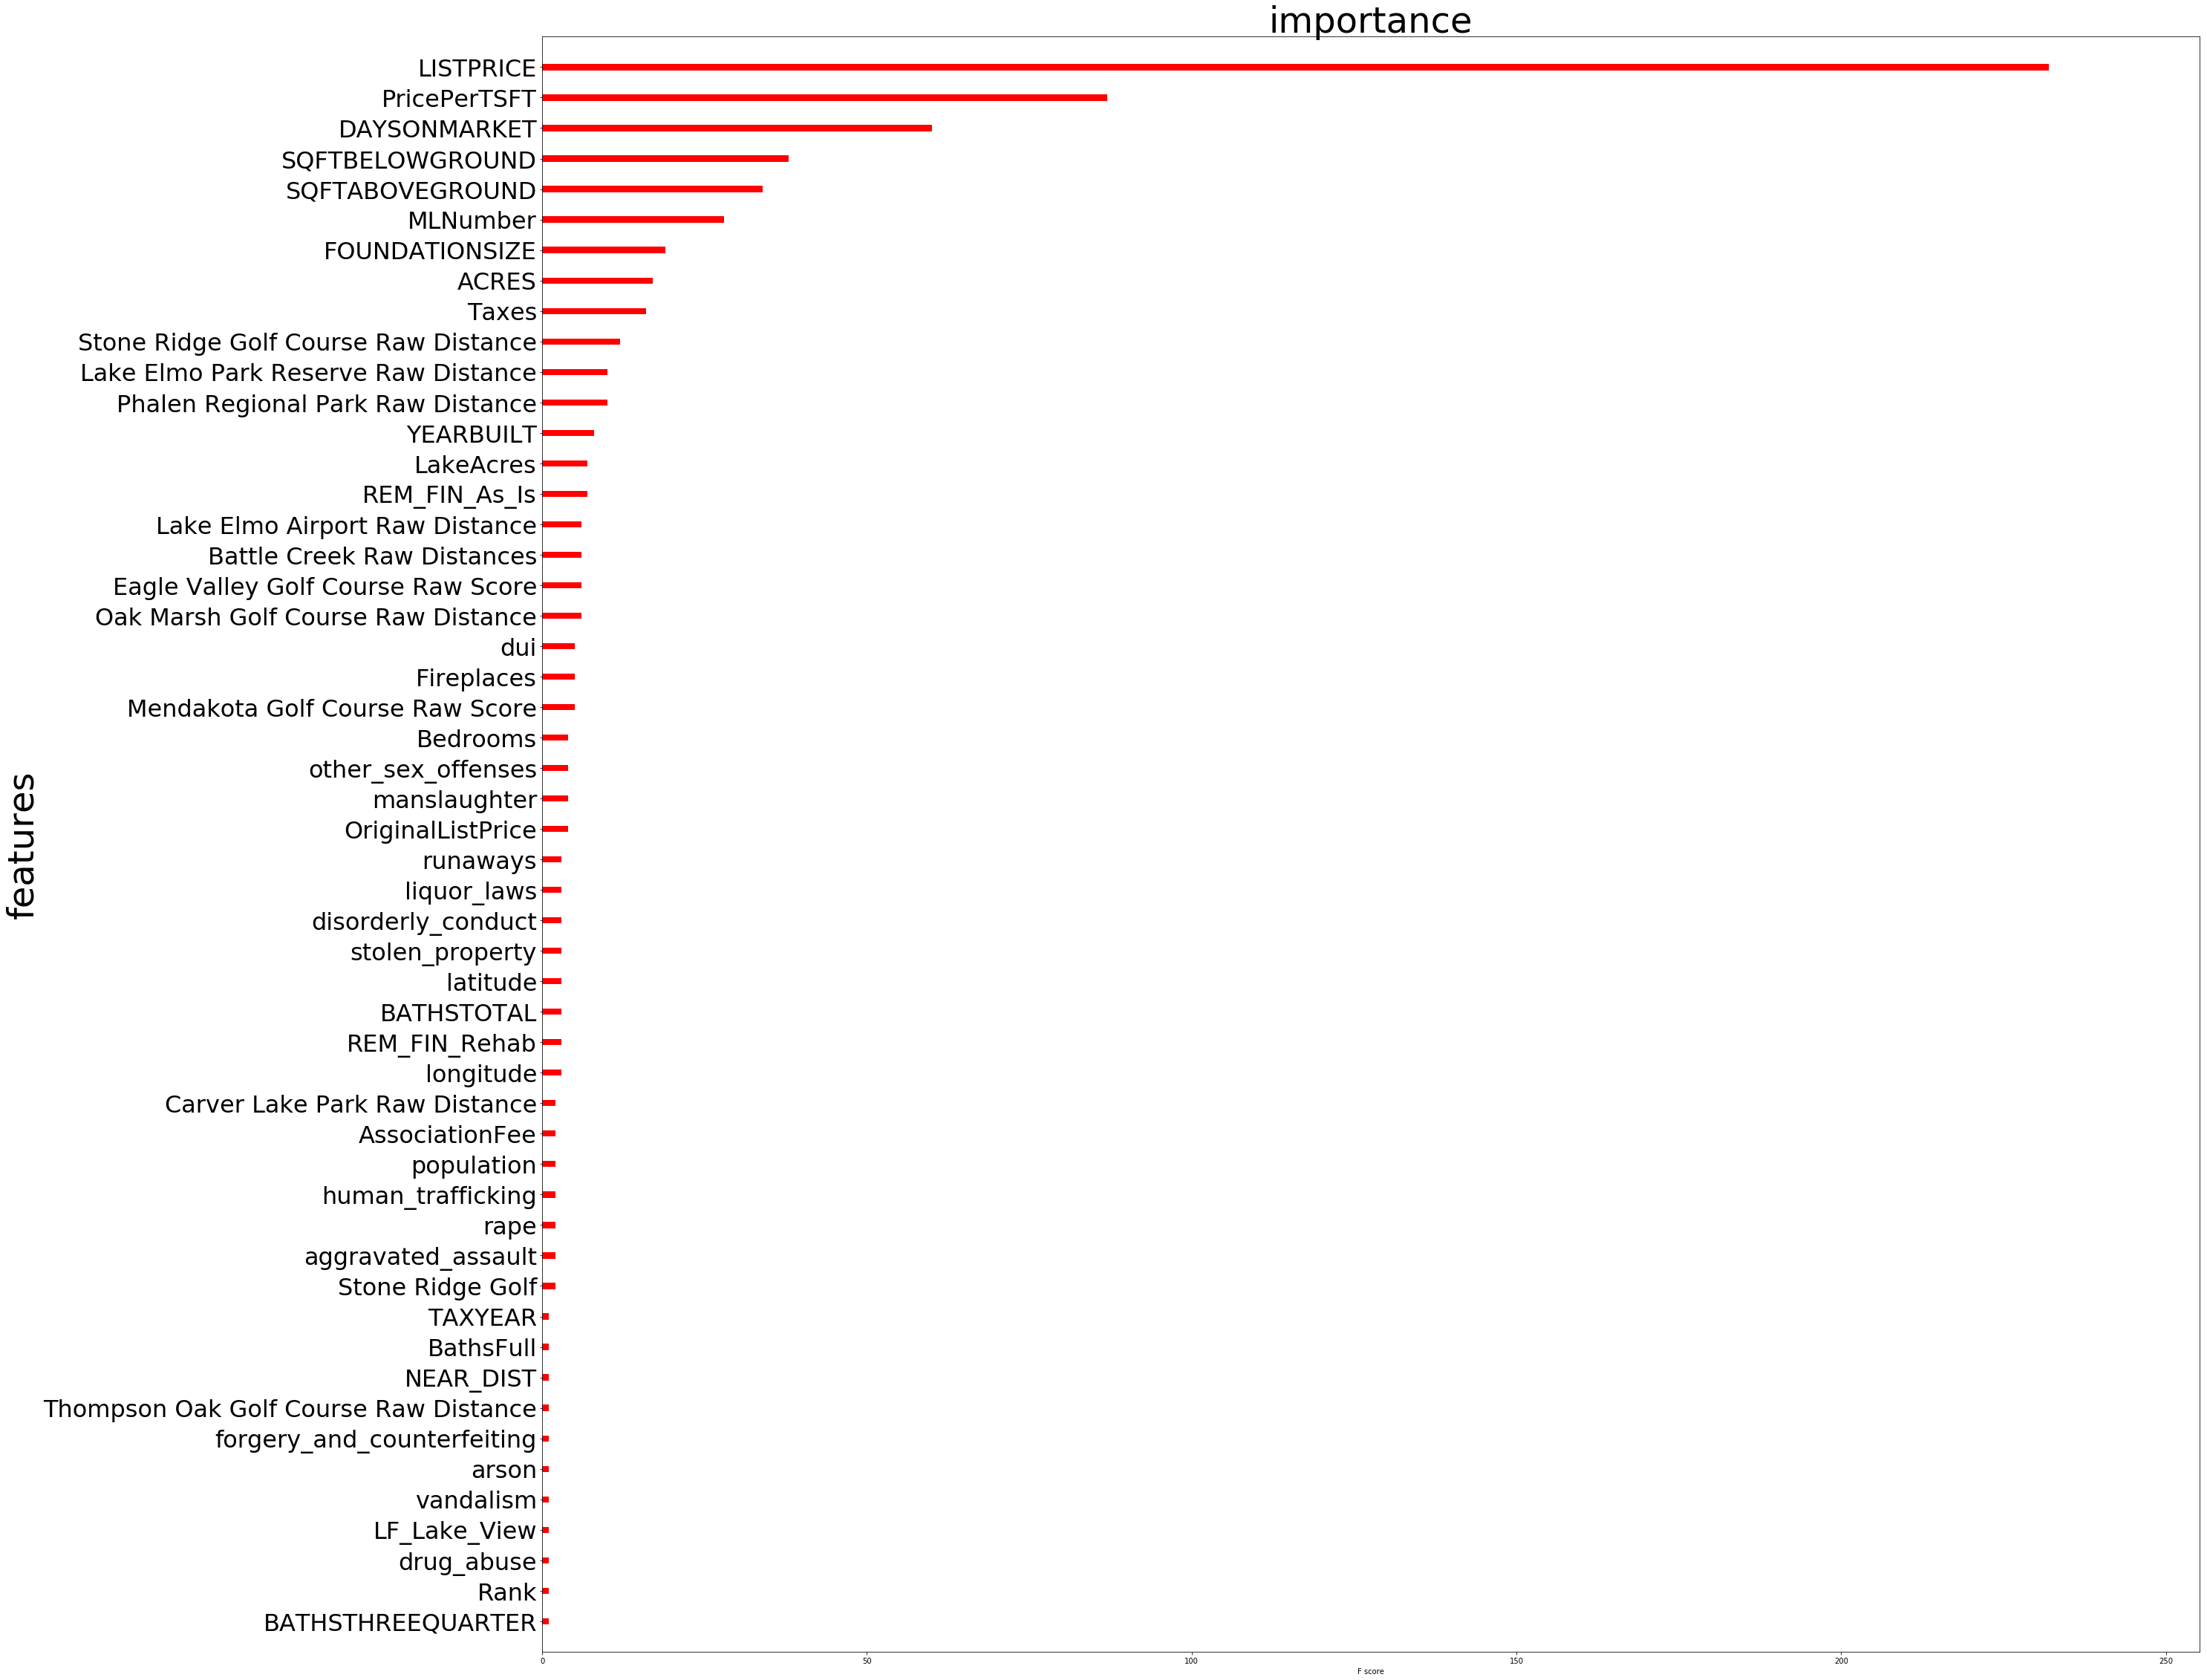

In [31]:
from xgboost import plot_importance
%matplotlib inline
from matplotlib import pyplot as plt

# feature importance
fig, ax = plt.subplots(figsize=(40, 40))
plot_importance(model_best, color='red', grid=False, show_values=False, ax=ax)
plt.title('importance', fontsize = 48)
plt.yticks(fontsize = 32)
plt.ylabel('features', fontsize = 48)

### What can we afford to lose?

* Too many variables can slow run time of model
* Can hamper explainability
* May be hard to curate
* May not be reported in a timely manner

In [40]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# fit model on all training data
model = xgb.XGBRegressor()
model.fit(Xtrain, ytrain)
# make predictions for test data and evaluate
ypred = model.predict(Xtest)
predictions = [round(value) for value in ypred]
r2 = r2_score(ytest, predictions)
print("r2: %.2f" % (r2))

r2: 0.99


In [39]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(Xtrain)
    # train model
    selection_model = xgb.XGBRegressor()
    selection_model.fit(select_X_train, ytrain)
    # eval model
    select_X_test = selection.transform(Xtest)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    r2 = r2_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, r2: %.2f%%" % (thresh, select_X_train.shape[1], r2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').